### Comparison to saturation genome editing

Author: Ruth Hanna

This notebook contains the code for Figure 2H, the comparison of data from the BRCA1 base editing screen to the BRCA1 saturation genome editing screen (Findlay et al. 2018). 

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import base_edit_functions as be
from scipy.stats import pearsonr
from colors import get_colors

mpl.rc('pdf', fonttype=42)
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
sns.set_context('paper')
sns.set_style('ticks')
color_dict = get_colors()

First, we load filtered LFC files and drop any columns we don't need for this analysis.

In [15]:
# Load data
brca1 = pd.read_csv('../Data/Filtered_LFC_files/Table_S2_filtered_BRCA1_v1.csv')

# Drop unnecessary columns
brca1 = brca1[['sgRNA sequence','sgRNA strand','Gene symbol','Nucleotide edits',
               'Amino acid edits','Mutation bin','AvgHAP1_MELJUSO;LFC_pdna;z-score']]
print brca1.shape
brca1.head()

(723, 7)


,sgRNA sequence,sgRNA strand,Gene symbol,Nucleotide edits,Amino acid edits,Mutation bin,AvgHAP1_MELJUSO;LFC_pdna;z-score
0,AAAACGACCACCCGAAACCT,NaN,Intergenic control,NaN,NaN,No edits,0.137103
1,AAAAGGACCCCATATAGCAC,antisense,BRCA1,C_8;,Exon23:+34;,Intron,-0.732224
2,AAAAGTGGTGGTATACGATA,antisense,BRCA1,NaN,NaN,No edits,-0.711219
3,AAACTTACTTGCAAAATATG,antisense,BRCA1,C_4;C_8;,Exon3:+5;Exon3:+1;,Splice site,-3.033019
4,AAAGAGATCATAGAAAAGAC,antisense,BRCA1,NaN,NaN,No edits,-3.087088


Next, we load "edit-level" annotations of the library -- this means that each row corresponds to a single predicted edit, and therefore each sgRNA can have multiple rows (if there are multiple predicted edits). We also clean up this dataframe a little, dropping duplicates and unnecessary columns.

In [7]:
edit_annot = pd.read_table('../Data/Annotations/0423_GC_filter_annotations/BRCA1_0422_20-04-22-17-23-50/clinvar_annotations_BRCA1_0422.txt')

# Drop duplicates and remove columns related to ClinVar annotations
# Dropping duplicates is important, otherwise edits with multiple matches to ClinVar
# will have multiple rows in the annotation file
edit_annot = edit_annot.drop_duplicates(subset=['sgRNA sequence','Edit nucleotide position(s)'])
edit_annot = edit_annot.loc[:,['sgRNA sequence',
                               'Edit nucleotide position(s)']]

edit_annot.head()

,sgRNA sequence,Edit nucleotide position(s)
0,AAATCTTAGAGTGTCCCATC,43124034
2,AGCACAAGAGTGTATTAATT,43124005
3,GCACAAGAGTGTATTAATTT,43124005
4,CCAGACTAGCAGGGTAGGGG,43115780
6,CCCCCCCTACCCTGCTAGTC,43115792


All we really need from this dataframe are the "edit nucleotide positions," so we merge those onto our scores file.

One thing we need to be attentive to is that sgRNAs may introduce multiple edits per codon, whereas the SGE screen only assayed single nucleotide variants. So, at least in our first pass of analysis, we don't want to include any sgRNAs that introduce multiple edits per codon, because those weren't assayed in the SGE data.

This might be a little overcautious. For example, in many cases an sgRNA may still introduce the same amino acid change, because the second edit in the codon is in the third position and therefore does not affect the coding sequence. However, we'll exclude any of these sgRNAs to be safe, since even edits in the third position could affect splicing.

In [8]:
def get_edit_nucs(sgrna):
    edit_nuc = edit_annot.loc[edit_annot['sgRNA sequence'] == sgrna,'Edit nucleotide position(s)'].tolist()
    # We join this list with "_" so that we can easily identify any sgRNAs with multiple edits/codon
    # (They will contain ";")
    return '_'.join(edit_nuc)
    
brca1['Edit nucleotides'] = brca1['sgRNA sequence'].apply(get_edit_nucs)
print brca1.shape
brca1.head()

(723, 8)


,sgRNA sequence,sgRNA strand,Gene symbol,Nucleotide edits,Amino acid edits,Mutation bin,AvgHAP1_MELJUSO;LFC_pdna;z-score,Edit nucleotides
0,AAAACGACCACCCGAAACCT,NaN,Intergenic control,NaN,NaN,No edits,0.137103,
1,AAAAGGACCCCATATAGCAC,antisense,BRCA1,C_8;,Exon23:+34;,Intron,-0.732224,43047609
2,AAAAGTGGTGGTATACGATA,antisense,BRCA1,NaN,NaN,No edits,-0.711219,
3,AAACTTACTTGCAAAATATG,antisense,BRCA1,C_4;C_8;,Exon3:+5;Exon3:+1;,Splice site,-3.033019,43115721_43115725
4,AAAGAGATCATAGAAAAGAC,antisense,BRCA1,NaN,NaN,No edits,-3.087088,


Next, we remove any sgRNAs that contain multiple edits per codon (as evidenced by the presence of ";" in the "Edit nucleotides" column). We also remove any sgRNAs predicted to make no edits, since those won't be helpful in our comparison to the SGE dataset.

In [9]:
filtered = brca1.loc[~brca1['Edit nucleotides'].str.contains(';')]
filtered = filtered.loc[filtered['Mutation bin'] != 'No edits']
print filtered.shape
filtered.head()

(272, 8)


,sgRNA sequence,sgRNA strand,Gene symbol,Nucleotide edits,Amino acid edits,Mutation bin,AvgHAP1_MELJUSO;LFC_pdna;z-score,Edit nucleotides
1,AAAAGGACCCCATATAGCAC,antisense,BRCA1,C_8;,Exon23:+34;,Intron,-0.732224,43047609
3,AAACTTACTTGCAAAATATG,antisense,BRCA1,C_4;C_8;,Exon3:+5;Exon3:+1;,Splice site,-3.033019,43115721_43115725
9,AAATAACAAGTGTTGGAAGC,antisense,BRCA1,C_7;,Leu1229Leu;,Silent,-0.083921,43091844
16,AAATCTTAGAGTGTCCCATC,sense,BRCA1,C_5;,Ile21Ile;,Silent,0.146696,43124034
19,AACCAATCAAGAAAGGATCC,antisense,BRCA1,C_4;C_8;,Gly1319Ser;Leu1317Leu;,Missense,-0.858230,43091576_43091580


Now we're ready to compare our data to the SGE data, obtained from the original publication. We've already converted the genomic positions to GRCh38 using liftOver.

In [10]:
sge_data = pd.read_table('../Data/External_datasets/BRCA1_BRCA2/SGE_BRCA1.txt')
print sge_data.shape
sge_data.head()

(3893, 65)


,gene,chromosome,position (hg19),position (hg38),reference,alt,snp_change,snp,transcript_ID,transcript_position,...,aGVGD.diff,aGVGD.class,clinvar,clinvar_simple,gnomAD_AF,bravo_AF,flossies_AF,WT.HAP1.function.score.r1,WT.HAP1.function.score.r2,WT.HAP1.function.score.mean
0,BRCA1,17,41276135,43124118,T,G,T>G,43124118:T>G,NM_007294.3,-22,...,NaN,NaN,absent,absent,0.000000,0.000000,0.0,0.369446,0.259903,0.314675
1,BRCA1,17,41276135,43124118,T,C,T>C,43124118:T>C,NM_007294.3,-22,...,NaN,NaN,Conflicting interpretations of pathogenicity,Conflicting interpretations of pathogenicity,0.000127,0.000167,0.0,-0.338637,0.301356,-0.018641
2,BRCA1,17,41276135,43124118,T,A,T>A,43124118:T>A,NM_007294.3,-22,...,NaN,NaN,absent,absent,0.000000,0.000000,0.0,-0.975176,-0.101218,-0.538197
3,BRCA1,17,41276134,43124117,T,G,T>G,43124117:T>G,NM_007294.3,-21,...,NaN,NaN,absent,absent,0.000000,0.000000,0.0,-1.766777,0.529892,-0.618443
4,BRCA1,17,41276134,43124117,T,C,T>C,43124117:T>C,NM_007294.3,-21,...,NaN,NaN,Pathogenic,Pathogenic,0.000000,0.000000,0.0,NaN,NaN,NaN


We drop some unnecessary columns.

In [11]:
sge_data = sge_data[['position (hg38)','reference','alt','protein_variant','function.score.mean']]
sge_data.head()

,position (hg38),reference,alt,protein_variant,function.score.mean
0,43124118,T,G,NaN,-0.372611
1,43124118,T,C,NaN,-0.045313
2,43124118,T,A,NaN,-0.108254
3,43124117,T,G,NaN,-0.277963
4,43124117,T,C,NaN,-0.388414


Now, for each row in the sgRNA dataframe, we get the function scores corresponding to each of the predicted edits. For example, if an sgRNA is predicted to make 3 edits, we would retrieve 3 SGE scores (one for each edit). We then return the minimum function score, reasoning that the edit with the strongest effect should drive the phenotype of the sgRNA.

It's worth noting that this is an imperfect assumption (for example, two edits may interact), but it is a reasonable way to get to a single score per sgRNA.

In [12]:
def get_sge_scores_v2(row):
    edit_nucs = row['Edit nucleotides'].split('_')
    scores = []
    variants = []
    not_found = False
    for nuc in edit_nucs:
        df = sge_data.loc[sge_data['position (hg38)'] == int(nuc),:]
        # If ANY of the edit nucleotides are not found in SGE data, return np.nan
        if len(df) == 0:
            not_found = True
            row['min_sge_score'] = np.nan 
            row['sge_variants'] = np.nan
        # Else, get mean function score for the C>T or G>A edit and append protein variant
        if list(set(df['reference'].tolist())) == ['C']:
            # Get function score and variants
            found_scores = df.loc[df['alt'] == 'T','function.score.mean'].tolist()
            if len(found_scores) == 0:
                not_found = True
            else:
                scores.extend(found_scores)
                variants.extend(df.loc[df['alt'] == 'T','protein_variant'].tolist())
        elif list(set(df['reference'].tolist())) == ['G']:
            # Get function score and variants
            found_scores = df.loc[df['alt'] == 'A','function.score.mean'].tolist()
            if len(found_scores) == 0:
                not_found = True
            else:
                scores.extend(found_scores)
                variants.extend(df.loc[df['alt'] == 'A','protein_variant'].tolist()) 
    # Return the minimum SGE score
    if not not_found:
        # Handle cases where scores is empty (e.g. nucleotide was assayed but C>T or G>A variant was not)
        if len(scores) == 0:
            row['min_sge_score'] = np.nan
        else:
            row['min_sge_score'] = min(scores)
        # Handle np.nan for non-coding variants    
        variants = [str(variant) for variant in variants] 
        row['sge_variants'] = ';'.join(variants)
    return row

filtered = filtered.apply(get_sge_scores_v2,axis=1)
# Drop rows that don't have SGE score
filtered = filtered.dropna(subset=['min_sge_score'])
print 'Total number of sgRNAs with combined SGE score = ' + str(len(filtered))
filtered.head()

Total number of sgRNAs with combined SGE score = 51


,Amino acid edits,AvgHAP1_MELJUSO;LFC_pdna;z-score,Edit nucleotides,Gene symbol,Mutation bin,Nucleotide edits,min_sge_score,sgRNA sequence,sgRNA strand,sge_variants
3,Exon3:+5;Exon3:+1;,-3.033019,43115721_43115725,BRCA1,Splice site,C_4;C_8;,-2.398164,AAACTTACTTGCAAAATATG,antisense,nan;nan
16,Ile21Ile;,0.146696,43124034,BRCA1,Silent,C_5;,-1.601567,AAATCTTAGAGTGTCCCATC,sense,p.I21=
24,Glu29Lys;Leu28Leu;,-0.651837,43115776_43115775,BRCA1,Missense,C_5;C_6;,-0.645512,AACTCCAGACTAGCAGGGTA,antisense,p.L28=;p.E29K
59,Thr1661Ile;,-3.912033,43070995,BRCA1,Missense,C_7;,-0.021899,AATTGACAGCTTCAACAGAA,sense,p.T1640I
75,Exon22:+10;,-1.092252,43049111,BRCA1,Intron,C_4;,-0.376090,ACCCAATACTTACTGTGCCA,antisense,nan


Finally, we correlate the sgRNA score with the minimum SGE score and observe a modest correlation (Pearson r = 0.44). We draw lines at the thresholds for LOF, intermediate, and functional SGE scores, as described in the original publication. This comparison is shown in __Figure 3H__. Colors indicate the predicted mutation bin of the sgRNA.

Pearson r = 0.44


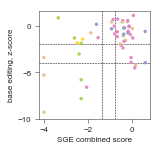

In [13]:
func_cutoff = -.748
lof_cutoff = -1.328

fig,ax = plt.subplots(figsize=(2,2))
sns.scatterplot(x='min_sge_score',y='AvgHAP1_MELJUSO;LFC_pdna;z-score',data=filtered,
                hue='Mutation bin',palette=color_dict,s=12,linewidth=0,legend=False,
                zorder=3)
ax.axvline(x=func_cutoff,color='black',linestyle='dashed',linewidth=0.5,zorder=2)
ax.axvline(x=lof_cutoff,color='black',linestyle='dashed',linewidth=0.5,zorder=2)
ax.axhline(y=(-2),color='black',linestyle='dashed',linewidth=0.5,zorder=2)
ax.axhline(y=(-4),color='black',linestyle='dashed',linewidth=0.5,zorder=2)
ax.set_xlabel('SGE combined score',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks([-10,-5,0],fontsize=8)   
ax.set_ylabel('base editing, z-score',fontsize=8)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
    ax.tick_params(width=0.5,length=4)

print 'Pearson r = ' + str(np.round(pearsonr(x=filtered['AvgHAP1_MELJUSO;LFC_pdna;z-score'],
                                             y=filtered['min_sge_score'])[0],2))
#fig.savefig('../Figures/Fig2_BRCA/Panels/SGE_comparison_v2.pdf',transparent=True,bbox_inches='tight')

We also determine the number of sgRNAs scoring in the different quadrants. Note that this doesn't add up to 51 because some sgRNAs score as "intermediate" hits in each dataset and therefore don't fall into one of the quadrants below.

In [14]:
print 'Number of sgRNAs scoring in both datasets = ' + str(len(filtered[(filtered['AvgHAP1_MELJUSO;LFC_pdna;z-score'] < -4) & (filtered['min_sge_score'] < lof_cutoff)]))
print 'Number of sgRNAs scoring in neither dataset = ' + str(len(filtered[(filtered['AvgHAP1_MELJUSO;LFC_pdna;z-score'] > -2) & (filtered['min_sge_score'] > func_cutoff)]))
print 'Number of sgRNAs scoring in base editor only = ' + str(len(filtered[(filtered['AvgHAP1_MELJUSO;LFC_pdna;z-score'] < -4) & (filtered['min_sge_score'] > func_cutoff)]))
print 'Number of sgRNAs scoring in SGE only = ' + str(len(filtered[(filtered['AvgHAP1_MELJUSO;LFC_pdna;z-score'] > -2) & (filtered['min_sge_score'] < lof_cutoff)]))


Number of sgRNAs scoring in both datasets = 5
Number of sgRNAs scoring in neither dataset = 24
Number of sgRNAs scoring in base editor only = 2
Number of sgRNAs scoring in SGE only = 8
